importing all python packages and loading both datasets.

Removing unwanted warnings

In [563]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [564]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


In [565]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load datasets
train = pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster/train.csv')
test = pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster/test.csv')


merging both datasets for preprocessing together.

In [566]:
data = pd.concat([train, test], sort=False).reset_index(drop=True)


getting info on the dataset.


In [567]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Data preprocessing.

In [568]:
data['Fare'].fillna(data['Fare'].mean(), inplace=True)

data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

#Extract titles
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace rare titles with 'Rare'
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

# putting similar titles together
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

# Extract the first letter from the Cabin column.
data['Deck'] = data['Cabin'].str[0]
data['Deck'] = data['Deck'].fillna('M')

#Creating total family members
data['totfam']=data['SibSp'] + data['Parch'] + 1

#dropping unwanted columns
data.drop(['Name','Ticket', 'PassengerId','Cabin','Parch','SibSp'], axis=1, inplace=True)

# Fill missing Age values based on median age for each title
data['Age'] = data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))



Data Overview

In [569]:
for col in data.columns:
    print(f"\nColumn: {col}")
    print(data[col].unique())


Column: Survived
[ 0.  1. nan]

Column: Pclass
[3 1 2]

Column: Sex
['male' 'female']

Column: Age
[22.   38.   26.   35.   29.   54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   65.   28.5   5.   11.   45.   17.   32.   16.
 25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.   14.5
 70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.   56.
 50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.   60.
 10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.    0.67
 47.5  30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]

Column: Fare
[  7.25        71.2833       7.925       53.1          8.05
   8.4583      51.8625      21.075       11.1333      30.0708
  16.7         26.55        31.275        7.8542      16.
  29.125       13.          18.           7.225       26.
   8.0292      35.5         31.3875     263.           7

Splitting cleaned data to train and test set back.

In [570]:
train_cleaned = data[:len(train)]
test_cleaned = data[len(train):]

Exploratory Analysis.

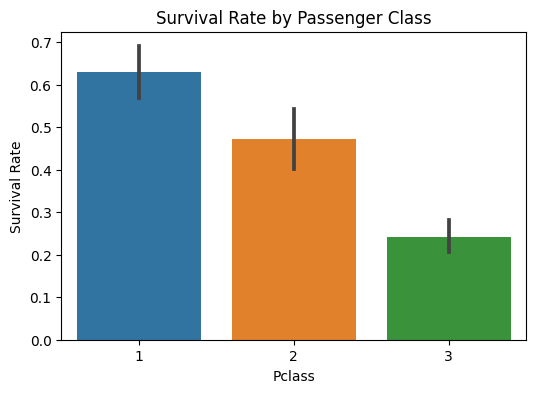

In [571]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.xlabel('Pclass')
plt.show()


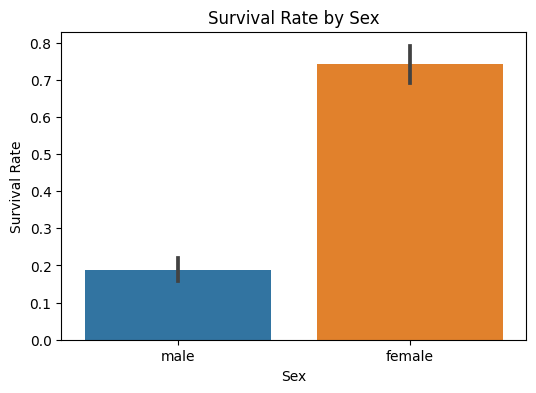

In [572]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')
plt.show()


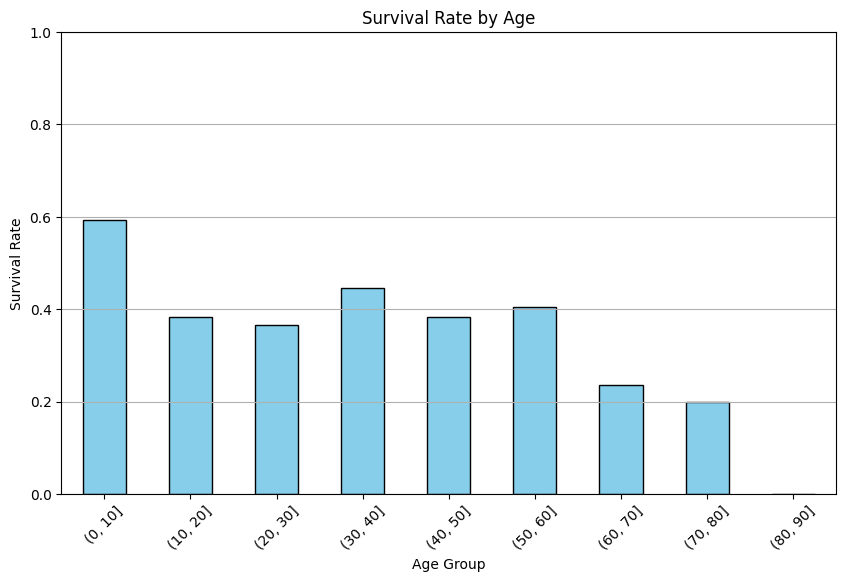

In [573]:
age_bins = pd.cut(train['Age'], bins=range(0, 91, 10))  

survival_by_age = train.groupby(age_bins)['Survived'].mean()

plt.figure(figsize=(10, 6))
survival_by_age.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Survival Rate by Age')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

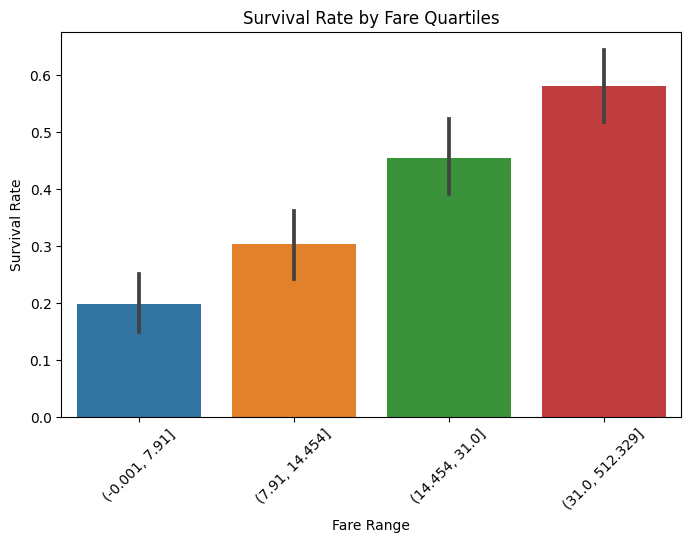

In [574]:
train['FareBin'] = pd.qcut(train['Fare'], 4)

plt.figure(figsize=(8, 5))
sns.barplot(x='FareBin', y='Survived', data=train)
plt.title('Survival Rate by Fare Quartiles')
plt.ylabel('Survival Rate')
plt.xlabel('Fare Range')
plt.xticks(rotation=45)
plt.show()


Taking correlations on a new dataset of numeric values.

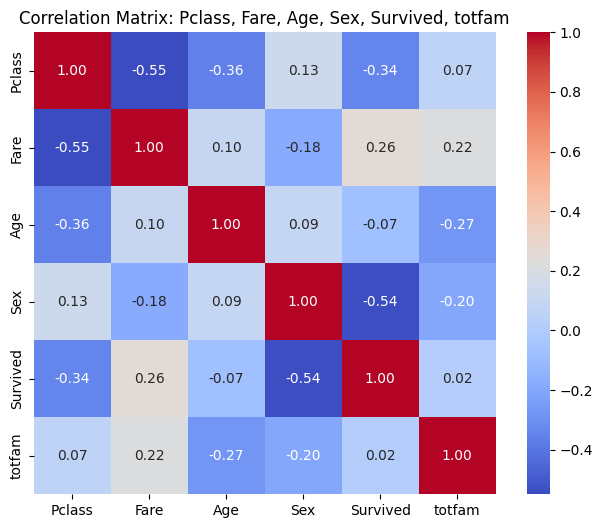

In [575]:
# Make a copy
df = train_cleaned.copy()

# Convert Sex to numeric
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

# Select columns
features = ['Pclass', 'Fare', 'Age', 'Sex', 'Survived', 'totfam']
corr_matrix = df[features].corr()

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix: Pclass, Fare, Age, Sex, Survived, totfam')
plt.show()


We can see the correlation matrix doesn't work well because the survived is a binary feature and correlation with a binary feature becomes hard.Hence the low correlation with Age.but it works well for Pclass and sex as the total values in such features are less.

In [576]:
print(train[['Pclass', 'Survived']].groupby('Pclass').mean())
print(train[['Sex', 'Survived']].groupby('Sex').mean())

group_data = train_cleaned.copy()
# Create bins
group_data['AgeGroup'] = pd.cut(group_data['Age'], bins=range(0, 81, 10), right=False)
group_data['FareGroup'] = pd.qcut(group_data['Fare'], q=4)

print(group_data[['AgeGroup', 'Survived']].groupby('AgeGroup').mean())
print(group_data[['FareGroup', 'Survived']].groupby('FareGroup').mean())



        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
        Survived
Sex             
female  0.742038
male    0.188908
          Survived
AgeGroup          
[0, 10)   0.606061
[10, 20)  0.401961
[20, 30)  0.301333
[30, 40)  0.472826
[40, 50)  0.377778
[50, 60)  0.416667
[60, 70)  0.315789
[70, 80)  0.000000
                 Survived
FareGroup                
(-0.001, 7.91]   0.197309
(7.91, 14.454]   0.303571
(14.454, 31.0]   0.454955
(31.0, 512.329]  0.581081


Dropping insignificant columns like Deck,Title etc

In [577]:

data.drop('Title', axis=1, inplace=True)
data.drop('Deck', axis=1, inplace=True)


Encoding Categorical Features

In [578]:

categorical_cols = ['Sex','Embarked']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

encoded_array = encoder.fit_transform(data[categorical_cols])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns
data = data.drop(categorical_cols, axis=1).reset_index(drop=True)

# Add encoded columns
data = pd.concat([data, encoded_df], axis=1)

train_cleaned = data[:len(train)]
test_cleaned = data[len(train):]


Model Building

Splitting into training and validation sets.

In [579]:
X =train_cleaned.drop('Survived', axis=1)
X_test = test_cleaned.drop('Survived',axis=1)
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [580]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   Fare        418 non-null    float64
 3   totfam      418 non-null    int64  
 4   Sex_female  418 non-null    float64
 5   Sex_male    418 non-null    float64
 6   Embarked_C  418 non-null    float64
 7   Embarked_Q  418 non-null    float64
 8   Embarked_S  418 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 29.5 KB


Logistic Regression

In [581]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
print("Logistic Regression:\n", classification_report(y_val, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



Random Forest Classifier

In [582]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("Random Forest:\n", classification_report(y_val, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Cross Validation

In [583]:
cv_scores_rf = cross_val_score(rf, X, y, cv=5)
print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f}")


Random Forest CV Accuracy: 0.8081


In [584]:

cv_scores_lr = cross_val_score(lr, X, y, cv=5)
print(f"Logistic Regression CV Accuracy: {cv_scores_lr.mean():.4f}")

Logistic Regression CV Accuracy: 0.7879


HyperParameter Tuning for better model .i.e.RandomForestClassifier

In [585]:
param_grid = {'n_estimators': [50,100, 200], 'max_depth': [5, 10,20, None]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X, y)
print("Best parameters:", grid.best_params_)


Best parameters: {'max_depth': 10, 'n_estimators': 100}


So we input these parameters into the RandomForestClassifier

In [586]:
 

final_model = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42)
final_model.fit(X, y) 



RandomForestClassifier(max_depth=10, random_state=42)

Predicting on the test set and getting final results

In [587]:
y_test_pred = final_model.predict(X_test)


In [588]:
test_passenger_ids = test['PassengerId'].copy()

submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,  
    'Survived': y_test_pred
})
submission.to_csv('submission.csv', index=False)


Final model's accuracy and precision

In [590]:
y_val_pred = final_model.predict(X_val)

# Classification report
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))

# Cross-validation accuracy
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       105
           1       0.94      0.91      0.92        74

    accuracy                           0.94       179
   macro avg       0.94      0.93      0.94       179
weighted avg       0.94      0.94      0.94       179

Cross-validation Accuracy: 0.8238
